In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
# pd.set_option('display.max_rows', 100)  # Adjust as needed (e.g., 100)
pd.set_option('display.max_columns', 50)  # Adjust as needed (e.g., 50)

In [18]:
data = pd.read_csv('../00.data/uber.csv')

In [19]:
data.shape

(200000, 9)

In [20]:
data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [21]:
# Missing Values
print("Missing values per column:")
print(data.isnull().sum())

Missing values per column:
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [20]:
import folium

sampled_data = data.sample(n=1000).copy()

# Create a base map
map_center = [sum(sampled_data['pickup_latitude']) / len(sampled_data['pickup_latitude']), sum(sampled_data['pickup_longitude']) / len(sampled_data['pickup_longitude'])]
m = folium.Map(location=map_center, zoom_start=12)

# Add markers to the map
for  lat, lon in zip( sampled_data['pickup_latitude'], sampled_data['pickup_longitude']):
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,  # Size of the dot
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.5,
        stroke=False,
        # icon=folium.Circle(color='blue')
    ).add_to(m)

# Display the map
# m.save('map.html')
print("Map has been saved as 'map.html'. Open it in a browser to view.")
m


Map has been saved as 'map.html'. Open it in a browser to view.


In [22]:
# Outlier Detection
from scipy.stats import zscore
import numpy as np
columns_to_check = ['pickup_latitude', 'pickup_longitude']
z_scores = np.abs(zscore(data[columns_to_check]))
# z_scores = np.abs(zscore(data.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).any(axis=1)
data_filtered = data[~outliers]
print(f"Number of outliers detected: {outliers.sum()}")

Number of outliers detected: 3942


In [23]:
data_filtered.shape

(196058, 9)

In [24]:
data_filtered = data_filtered[(data_filtered['pickup_longitude'] > -74.247671) & (data_filtered['pickup_longitude'] < -73.683388) & (data_filtered['pickup_latitude'] > 40.468496) & (data_filtered['pickup_latitude'] < 41.366331)]

In [25]:
data_filtered = data_filtered[(data_filtered['dropoff_longitude'] > -74.247671) & (data_filtered['dropoff_longitude'] < -73.683388) & (data_filtered['dropoff_latitude'] > 40.468496) & (data_filtered['dropoff_latitude'] < 41.366331)]

In [26]:
data_filtered.shape

(195605, 9)

In [11]:
import folium

sampled_data = data_filtered.sample(n=1000).copy()

# Create a base map
map_center = [sum(sampled_data['pickup_latitude']) / len(sampled_data['pickup_latitude']), sum(sampled_data['pickup_longitude']) / len(sampled_data['pickup_longitude'])]
m = folium.Map(location=map_center, zoom_start=12)

# Add markers to the map
for  lat, lon in zip( sampled_data['pickup_latitude'], sampled_data['pickup_longitude']):
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,  # Size of the dot
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.5,
        stroke=False,
        # icon=folium.Circle(color='blue')
    ).add_to(m)

# Display the map
# m.save('map.html')
print("Map has been saved as 'map.html'. Open it in a browser to view.")
m


Map has been saved as 'map.html'. Open it in a browser to view.


In [27]:
data = data_filtered
data.shape

(195605, 9)

In [28]:
# add drived variables
data['pickup_DTM'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_hour'] = data['pickup_DTM'].dt.hour
data['pickup_year'] = data['pickup_DTM'].dt.year
data['pickup_month'] = data['pickup_DTM'].dt.month
data['pickup_weekday'] = data['pickup_DTM'].dt.day_name()

In [29]:
# Haversine function to calculate distance
# calculate the distance between two sets of latitude and longitude coordinates using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth's surface.
    Parameters:
        lat1, lon1: Latitude and Longitude of the first location
        lat2, lon2: Latitude and Longitude of the second location
    Returns:
        Distance in kilometers
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Apply the Haversine function to calculate distances
data['distance_km'] = data.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],
                                                  row['dropoff_latitude'], row['dropoff_longitude']), axis=1)


In [30]:
data.head(7)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_DTM,pickup_hour,pickup_year,pickup_month,pickup_weekday,distance_km
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,2015-05-07 19:52:06+00:00,19,2015,5,Thursday,1.683323
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2009-07-17 20:04:56+00:00,20,2009,7,Friday,2.457590
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,2009-08-24 21:45:00+00:00,21,2009,8,Monday,5.036377
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,2009-06-26 08:22:21+00:00,8,2009,6,Friday,1.661683
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,2014-08-28 17:47:00+00:00,17,2014,8,Thursday,4.475450
5,44470845,2011-02-12 02:27:09.0000006,4.9,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1,2011-02-12 02:27:09+00:00,2,2011,2,Saturday,0.000000
6,48725865,2014-10-12 07:04:00.0000002,24.5,2014-10-12 07:04:00 UTC,-73.961447,40.693965,-73.871195,40.774297,5,2014-10-12 07:04:00+00:00,7,2014,10,Sunday,11.731015


In [31]:
data = data[data['distance_km'] > 0.000001]
data.shape

(193641, 15)

In [32]:
data = data[data['pickup_year'] < 2015]
data.shape

(180180, 15)

In [33]:
data['passenger_count'].value_counts()

passenger_count
1      124473
2       26644
5       12814
3        8047
4        3879
6        3644
0         678
208         1
Name: count, dtype: int64

In [34]:
data = data[(data['passenger_count'] > 0) & (data['passenger_count'] < 10)]
data.shape

(179501, 15)

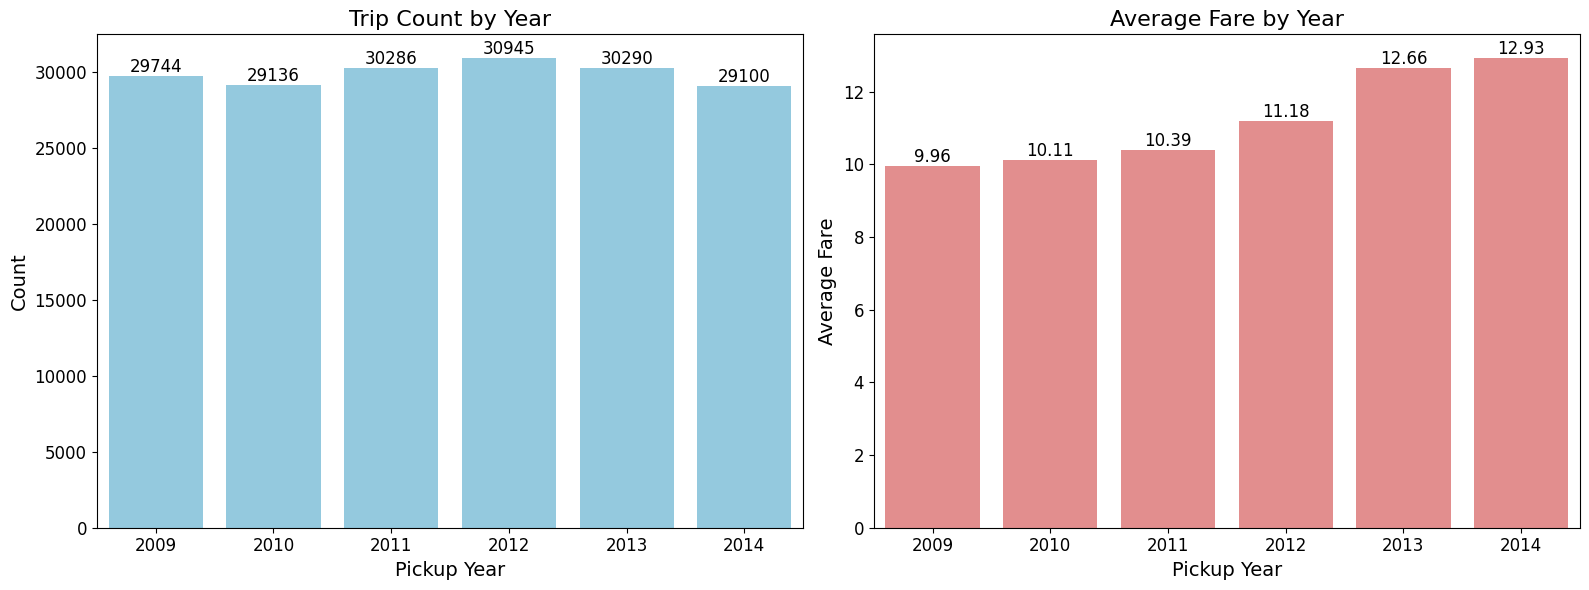

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data for count and average fare
trip_count = data.groupby('pickup_year').size().reset_index(name='count')
average_fare = data.groupby('pickup_year')['fare_amount'].mean().reset_index()

# Ensure 'pickup_year' is treated as categorical for proper ordering in plots
trip_count['pickup_year'] = trip_count['pickup_year'].astype(str)
average_fare['pickup_year'] = average_fare['pickup_year'].astype(str)

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Left Plot: Count of trips
sns.barplot(data=trip_count, x='pickup_year', y='count', ax=axes[0], color='skyblue')  # Use a single color
axes[0].set_title('Trip Count by Year', fontsize=16)
axes[0].set_xlabel('Pickup Year', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)  # Increase x-tick font size
axes[0].tick_params(axis='y', labelsize=12)  # Increase y-tick font size

# Add labels above bars for count plot
for bar in axes[0].containers[0]:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                 ha='center', va='bottom', fontsize=12)

# Right Plot: Average fare
sns.barplot(data=average_fare, x='pickup_year', y='fare_amount', ax=axes[1], color='lightcoral')  # Use a single color
axes[1].set_title('Average Fare by Year', fontsize=16)
axes[1].set_xlabel('Pickup Year', fontsize=14)
axes[1].set_ylabel('Average Fare', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)  # Increase x-tick font size
axes[1].tick_params(axis='y', labelsize=12)  # Increase y-tick font size

# Add labels above bars for average fare plot
for bar in axes[1].containers[0]:
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
                 ha='center', va='bottom', fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


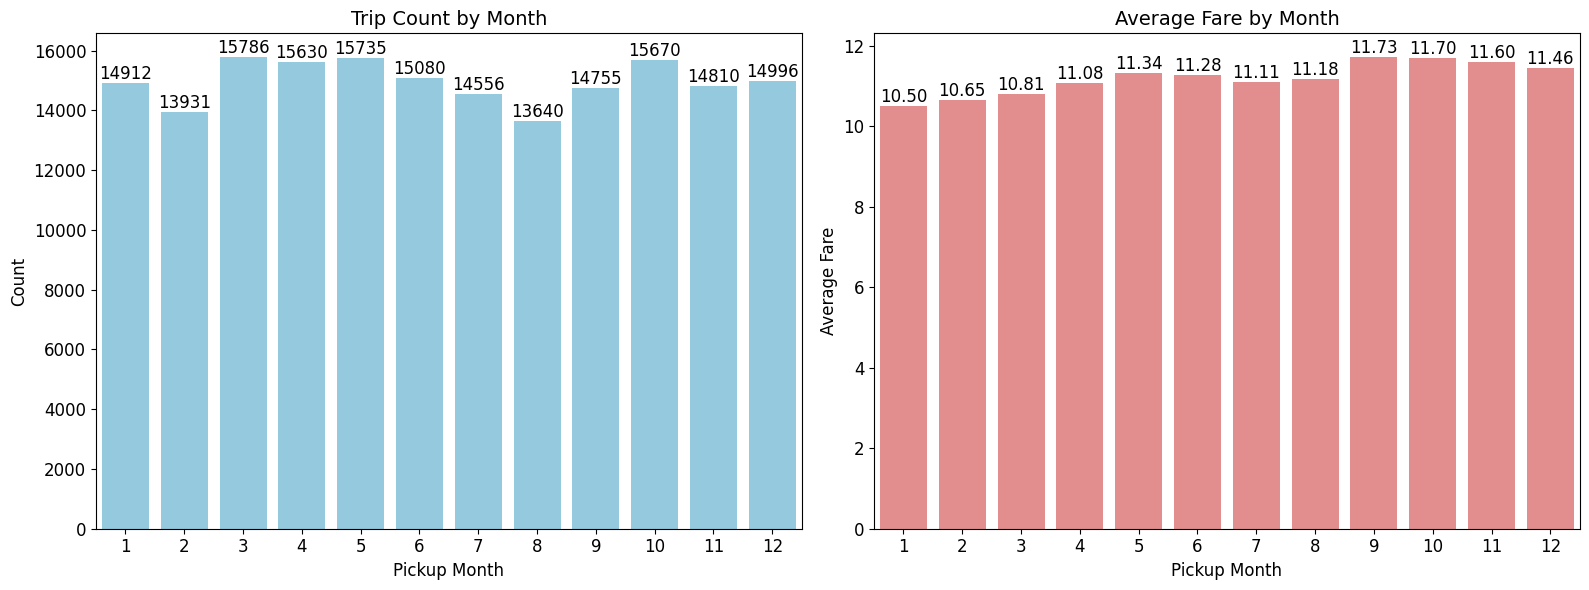

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data for count and average fare by pickup_month
trip_count = data[data['pickup_year'] < 2015].groupby('pickup_month').size().reset_index(name='count')
average_fare = data[data['pickup_year'] < 2015].groupby('pickup_month')['fare_amount'].mean().reset_index()

# Ensure 'pickup_month' is treated as categorical for proper ordering in plots
trip_count['pickup_month'] = trip_count['pickup_month'].astype(str)
average_fare['pickup_month'] = average_fare['pickup_month'].astype(str)

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Left Plot: Count of trips by month
sns.barplot(data=trip_count, x='pickup_month', y='count', ax=axes[0], color='skyblue')  # Use a single color
axes[0].set_title('Trip Count by Month', fontsize=14)
axes[0].set_xlabel('Pickup Month', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', labelsize=12)  # Increase x-tick font size
axes[0].tick_params(axis='y', labelsize=12)  # Increase y-tick font size

# Add labels above bars for count plot
for bar in axes[0].containers[0]:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                 ha='center', va='bottom', fontsize=12)

# Right Plot: Average fare by month
sns.barplot(data=average_fare, x='pickup_month', y='fare_amount', ax=axes[1], color='lightcoral')  # Use a single color
axes[1].set_title('Average Fare by Month', fontsize=14)
axes[1].set_xlabel('Pickup Month', fontsize=12)
axes[1].set_ylabel('Average Fare', fontsize=12)
axes[1].tick_params(axis='x', labelsize=12)  # Increase x-tick font size
axes[1].tick_params(axis='y', labelsize=12)  # Increase y-tick font size

# Add labels above bars for average fare plot
for bar in axes[1].containers[0]:
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
                 ha='center', va='bottom', fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


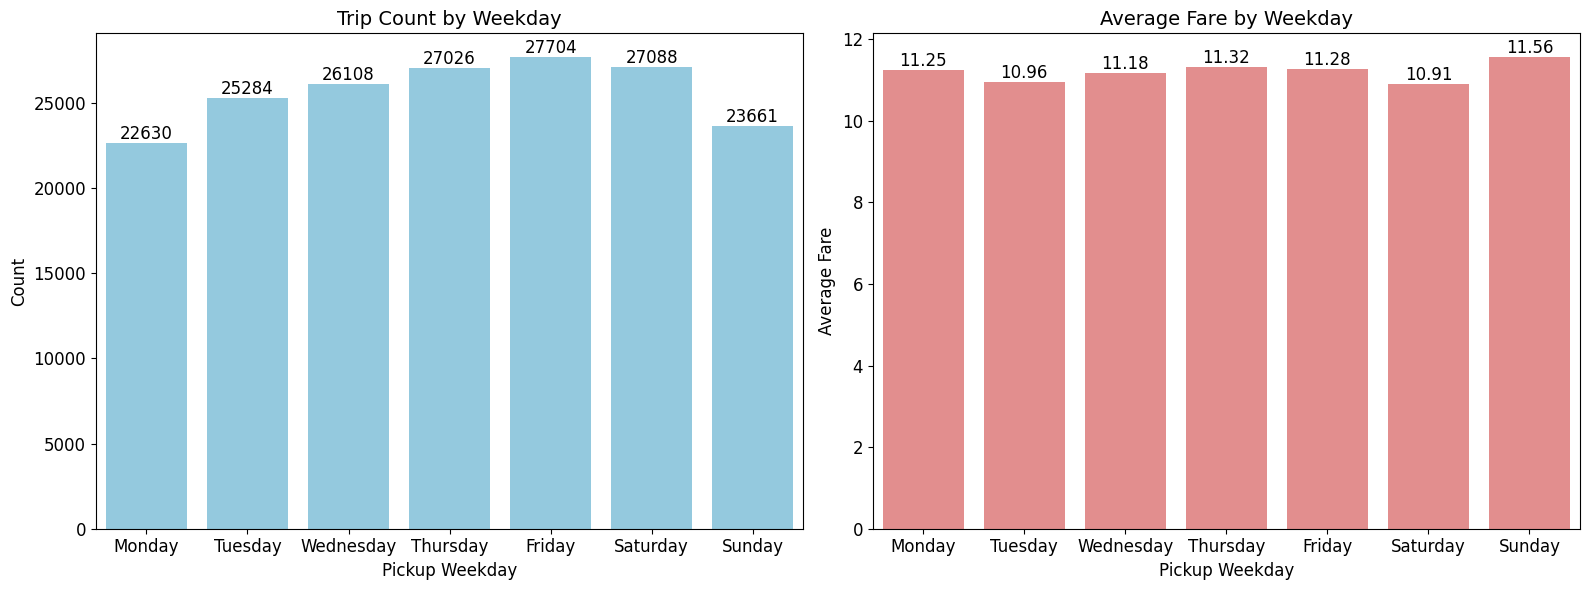

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data for count and average fare by pickup_weekday
trip_count = data.groupby('pickup_weekday').size().reset_index(name='count')
average_fare = data.groupby('pickup_weekday')['fare_amount'].mean().reset_index()

# Ensure `pickup_weekday` is ordered properly (e.g., Monday to Sunday)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trip_count['pickup_weekday'] = pd.Categorical(trip_count['pickup_weekday'], categories=weekday_order, ordered=True)
average_fare['pickup_weekday'] = pd.Categorical(average_fare['pickup_weekday'], categories=weekday_order, ordered=True)

# Sort data by the defined order
trip_count = trip_count.sort_values(by='pickup_weekday')
average_fare = average_fare.sort_values(by='pickup_weekday')

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Left Plot: Count of trips by weekday
sns.barplot(data=trip_count, x='pickup_weekday', y='count', ax=axes[0], color='skyblue')
axes[0].set_title('Trip Count by Weekday', fontsize=14)
axes[0].set_xlabel('Pickup Weekday', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Add labels above bars for count plot
for bar in axes[0].containers[0]:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                 ha='center', va='bottom', fontsize=12)

# Right Plot: Average fare by weekday
sns.barplot(data=average_fare, x='pickup_weekday', y='fare_amount', ax=axes[1], color='lightcoral')
axes[1].set_title('Average Fare by Weekday', fontsize=14)
axes[1].set_xlabel('Pickup Weekday', fontsize=12)
axes[1].set_ylabel('Average Fare', fontsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Add labels above bars for average fare plot
for bar in axes[1].containers[0]:
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
                 ha='center', va='bottom', fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


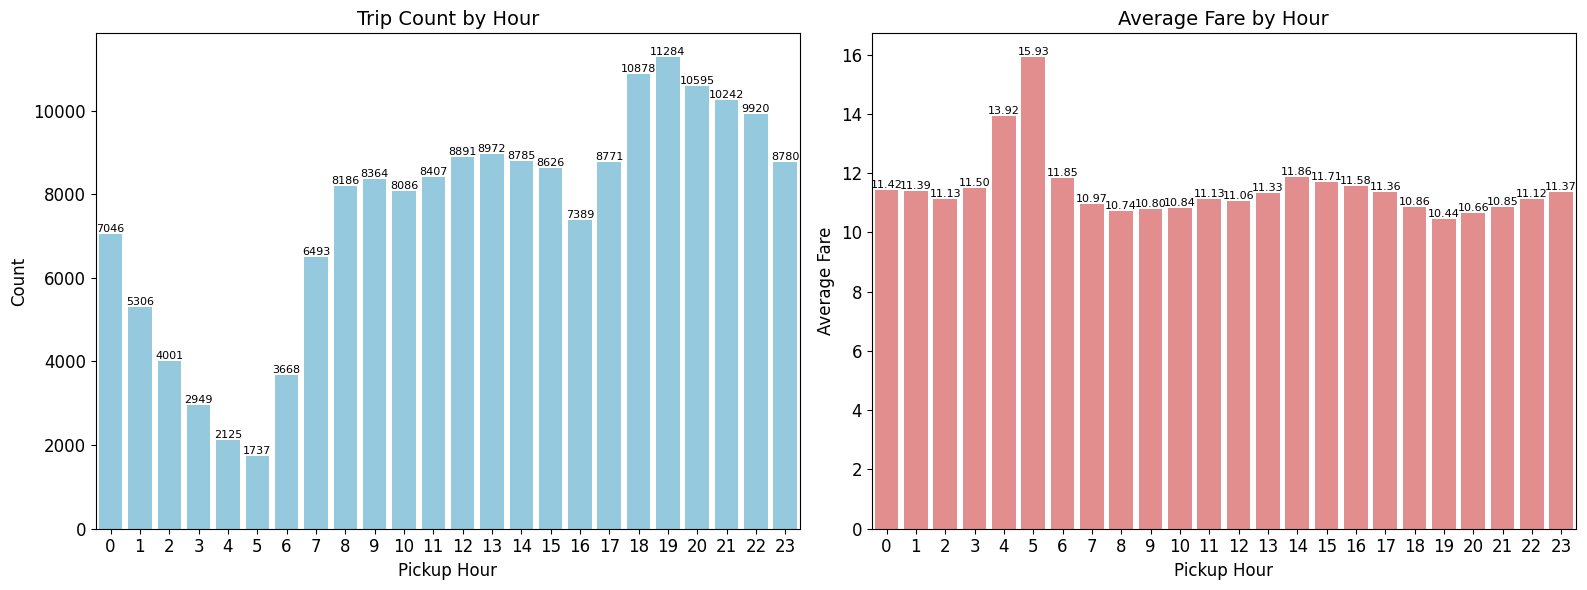

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data for count and average fare by pickup_hour
trip_count = data.groupby('pickup_hour').size().reset_index(name='count')
average_fare = data.groupby('pickup_hour')['fare_amount'].mean().reset_index()

# Ensure `pickup_hour` is treated as categorical for proper ordering in plots
trip_count['pickup_hour'] = trip_count['pickup_hour'].astype(int)
average_fare['pickup_hour'] = average_fare['pickup_hour'].astype(int)

# Sort the data by hour
trip_count = trip_count.sort_values(by='pickup_hour')
average_fare = average_fare.sort_values(by='pickup_hour')

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Left Plot: Count of trips by hour
sns.barplot(data=trip_count, x='pickup_hour', y='count', ax=axes[0], color='skyblue')
axes[0].set_title('Trip Count by Hour', fontsize=14)
axes[0].set_xlabel('Pickup Hour', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Add labels above bars for count plot
for bar in axes[0].containers[0]:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                 ha='center', va='bottom', fontsize=8)

# Right Plot: Average fare by hour
sns.barplot(data=average_fare, x='pickup_hour', y='fare_amount', ax=axes[1], color='lightcoral')
axes[1].set_title('Average Fare by Hour', fontsize=14)
axes[1].set_xlabel('Pickup Hour', fontsize=12)
axes[1].set_ylabel('Average Fare', fontsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Add labels above bars for average fare plot
for bar in axes[1].containers[0]:
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
                 ha='center', va='bottom', fontsize=8)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_48096\2343224752.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_count = data.groupby('distance_range').size().reset_index(name='count')
C:\Users\simon\AppData\Local\Temp\ipykernel_48096\2343224752.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_fare = data.groupby('distance_range')['fare_amount'].mean().reset_index()


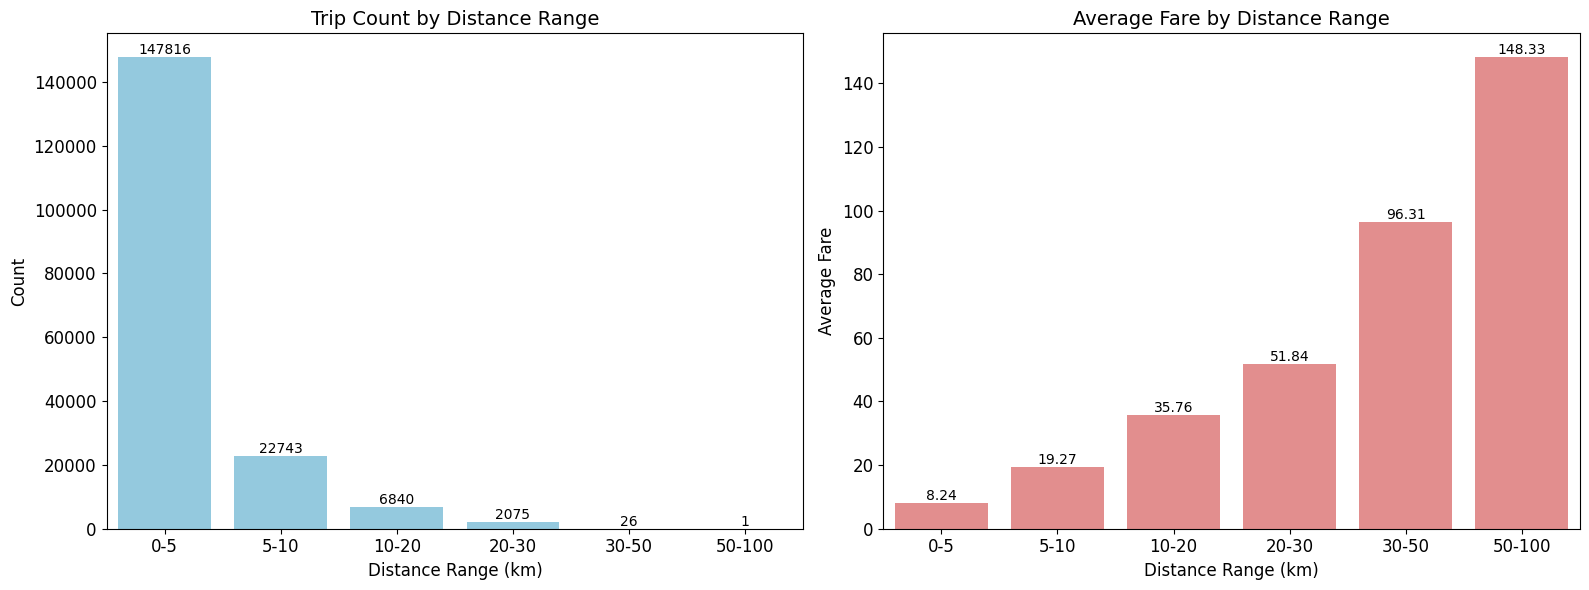

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Bin the distance into ranges (e.g., 0-5 km, 5-10 km, etc.)
bins = [0, 5, 10, 20, 30, 50, 100]
labels = ['0-5', '5-10', '10-20', '20-30', '30-50', '50-100']
data['distance_range'] = pd.cut(data['distance_km'], bins=bins, labels=labels, include_lowest=True)

# Group data for count and average fare by distance range
trip_count = data.groupby('distance_range').size().reset_index(name='count')
average_fare = data.groupby('distance_range')['fare_amount'].mean().reset_index()

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Left Plot: Count of trips by distance range
sns.barplot(data=trip_count, x='distance_range', y='count', ax=axes[0], color='skyblue')
axes[0].set_title('Trip Count by Distance Range', fontsize=14)
axes[0].set_xlabel('Distance Range (km)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Add labels above bars for count plot
for bar in axes[0].containers[0]:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                 ha='center', va='bottom', fontsize=10)

# Right Plot: Average fare by distance range
sns.barplot(data=average_fare, x='distance_range', y='fare_amount', ax=axes[1], color='lightcoral')
axes[1].set_title('Average Fare by Distance Range', fontsize=14)
axes[1].set_xlabel('Distance Range (km)', fontsize=12)
axes[1].set_ylabel('Average Fare', fontsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Add labels above bars for average fare plot
for bar in axes[1].containers[0]:
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
                 ha='center', va='bottom', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_48096\1908619642.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_count = data.groupby('distance_range').size().reset_index(name='count')
C:\Users\simon\AppData\Local\Temp\ipykernel_48096\1908619642.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_fare = data.groupby('distance_range')['fare_amount'].mean().reset_index()


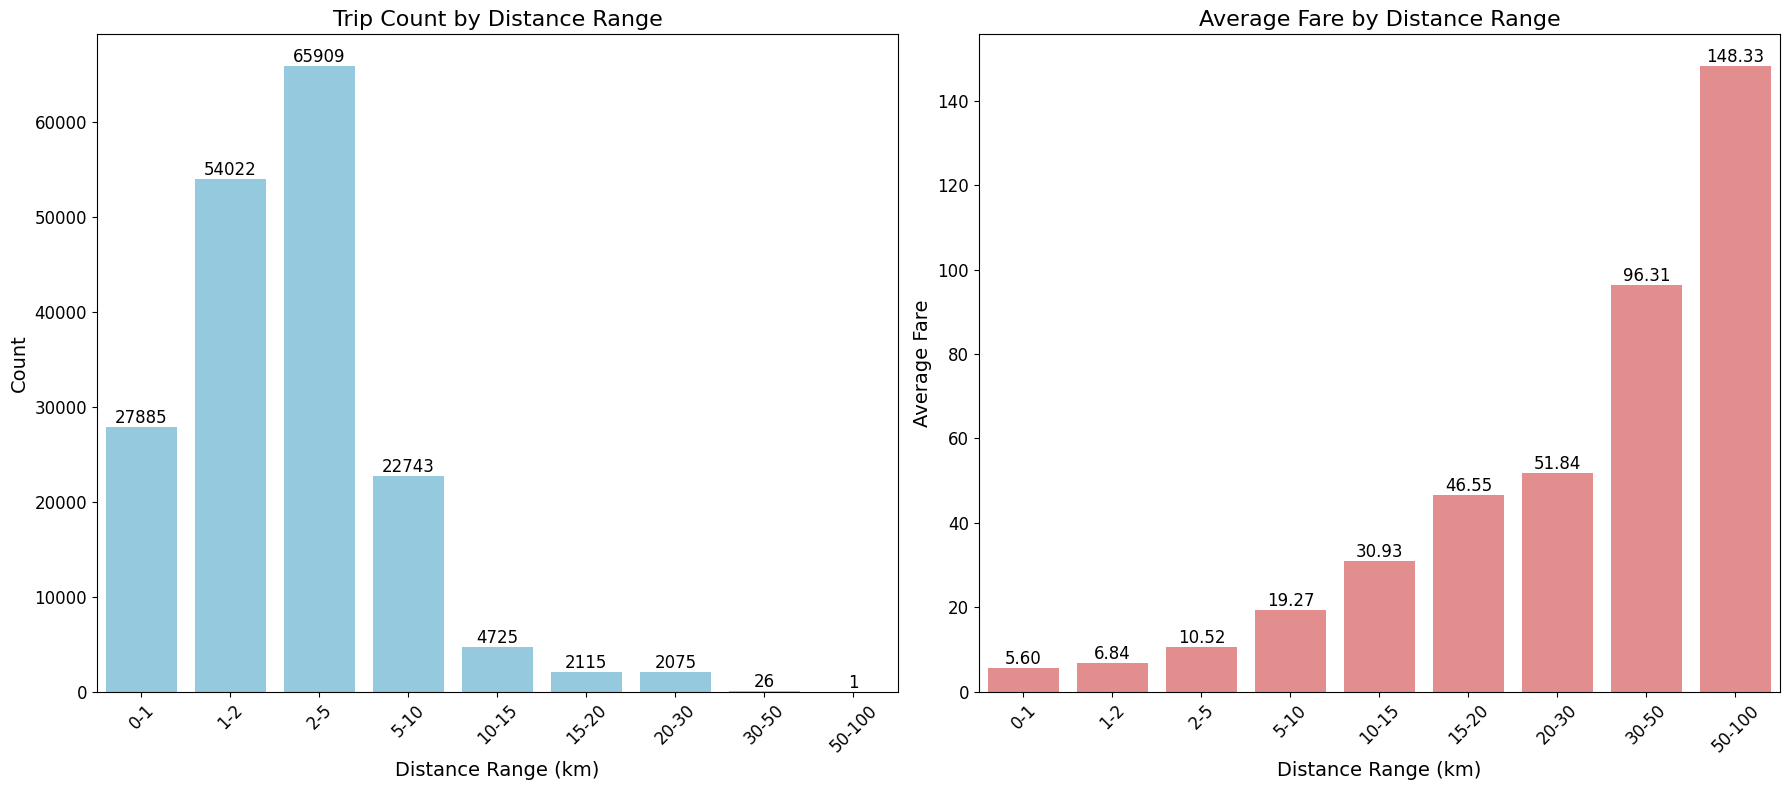

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define finer bins for distance ranges
bins = [0, 1, 2, 5, 10, 15, 20, 30, 50, 100]
labels = ['0-1', '1-2', '2-5', '5-10', '10-15', '15-20', '20-30', '30-50', '50-100']
data['distance_range'] = pd.cut(data['distance_km'], bins=bins, labels=labels, include_lowest=True)

# Group data for count and average fare by distance range
trip_count = data.groupby('distance_range').size().reset_index(name='count')
average_fare = data.groupby('distance_range')['fare_amount'].mean().reset_index()

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)

# Left Plot: Count of trips by distance range
sns.barplot(data=trip_count, x='distance_range', y='count', ax=axes[0], color='skyblue')
axes[0].set_title('Trip Count by Distance Range', fontsize=16)
axes[0].set_xlabel('Distance Range (km)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12, rotation=45)  # Rotate for better readability
axes[0].tick_params(axis='y', labelsize=12)

# Add labels above bars for count plot
for bar in axes[0].containers[0]:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                 ha='center', va='bottom', fontsize=12)

# Right Plot: Average fare by distance range
sns.barplot(data=average_fare, x='distance_range', y='fare_amount', ax=axes[1], color='lightcoral')
axes[1].set_title('Average Fare by Distance Range', fontsize=16)
axes[1].set_xlabel('Distance Range (km)', fontsize=14)
axes[1].set_ylabel('Average Fare', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12, rotation=45)  # Rotate for better readability
axes[1].tick_params(axis='y', labelsize=12)

# Add labels above bars for average fare plot
for bar in axes[1].containers[0]:
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
                 ha='center', va='bottom', fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


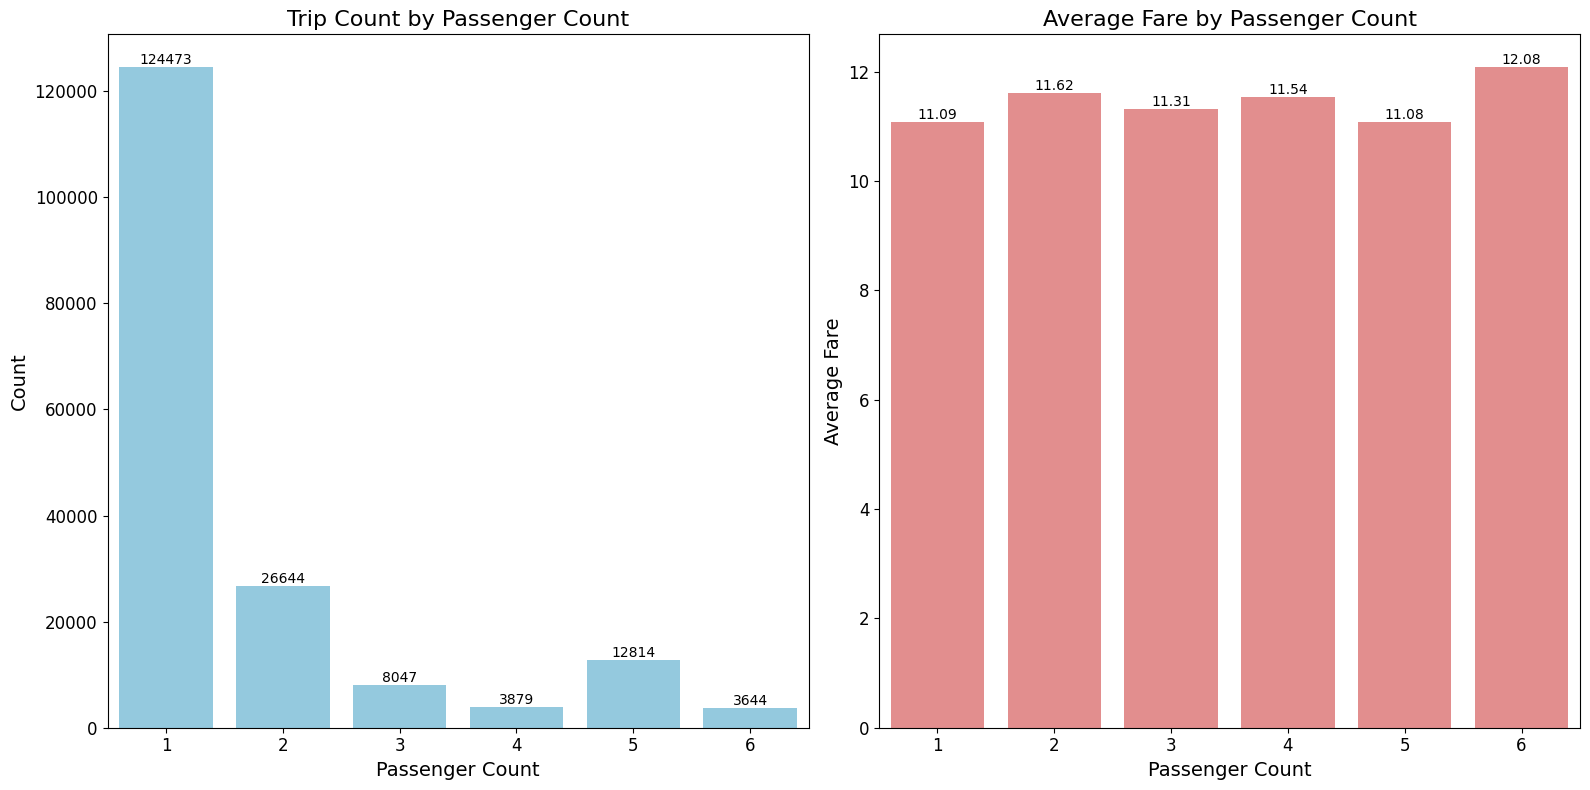

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Group data for count and average fare by passenger_count
trip_count = data[(data['passenger_count'] > 0) & (data['passenger_count'] < 10)].groupby('passenger_count').size().reset_index(name='count')
average_fare = data[(data['passenger_count'] > 0) & (data['passenger_count'] < 10)].groupby('passenger_count')['fare_amount'].mean().reset_index()

# Ensure passenger_count is sorted numerically
trip_count['passenger_count'] = trip_count['passenger_count'].astype(int)
average_fare['passenger_count'] = average_fare['passenger_count'].astype(int)

# Sort data by passenger_count
trip_count = trip_count.sort_values(by='passenger_count')
average_fare = average_fare.sort_values(by='passenger_count')

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

# Left Plot: Count of trips by passenger_count
sns.barplot(data=trip_count, x='passenger_count', y='count', ax=axes[0], color='skyblue')
axes[0].set_title('Trip Count by Passenger Count', fontsize=16)
axes[0].set_xlabel('Passenger Count', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Add labels above bars for count plot
for bar in axes[0].containers[0]:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                 ha='center', va='bottom', fontsize=10)

# Right Plot: Average fare by passenger_count
sns.barplot(data=average_fare, x='passenger_count', y='fare_amount', ax=axes[1], color='lightcoral')
axes[1].set_title('Average Fare by Passenger Count', fontsize=16)
axes[1].set_xlabel('Passenger Count', fontsize=14)
axes[1].set_ylabel('Average Fare', fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Add labels above bars for average fare plot
for bar in axes[1].containers[0]:
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}', 
                 ha='center', va='bottom', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_48096\2126380817.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data[(data['passenger_count'] > 0) & (data['passenger_count'] < 10)].groupby(['passenger_count', 'distance_range'])
C:\Users\simon\AppData\Local\Temp\ipykernel_48096\2126380817.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data[(data['passenger_count'] > 0) & (data['passenger_count'] < 10)].groupby(['passenger_count', 'distance_range'])['fare_amount']


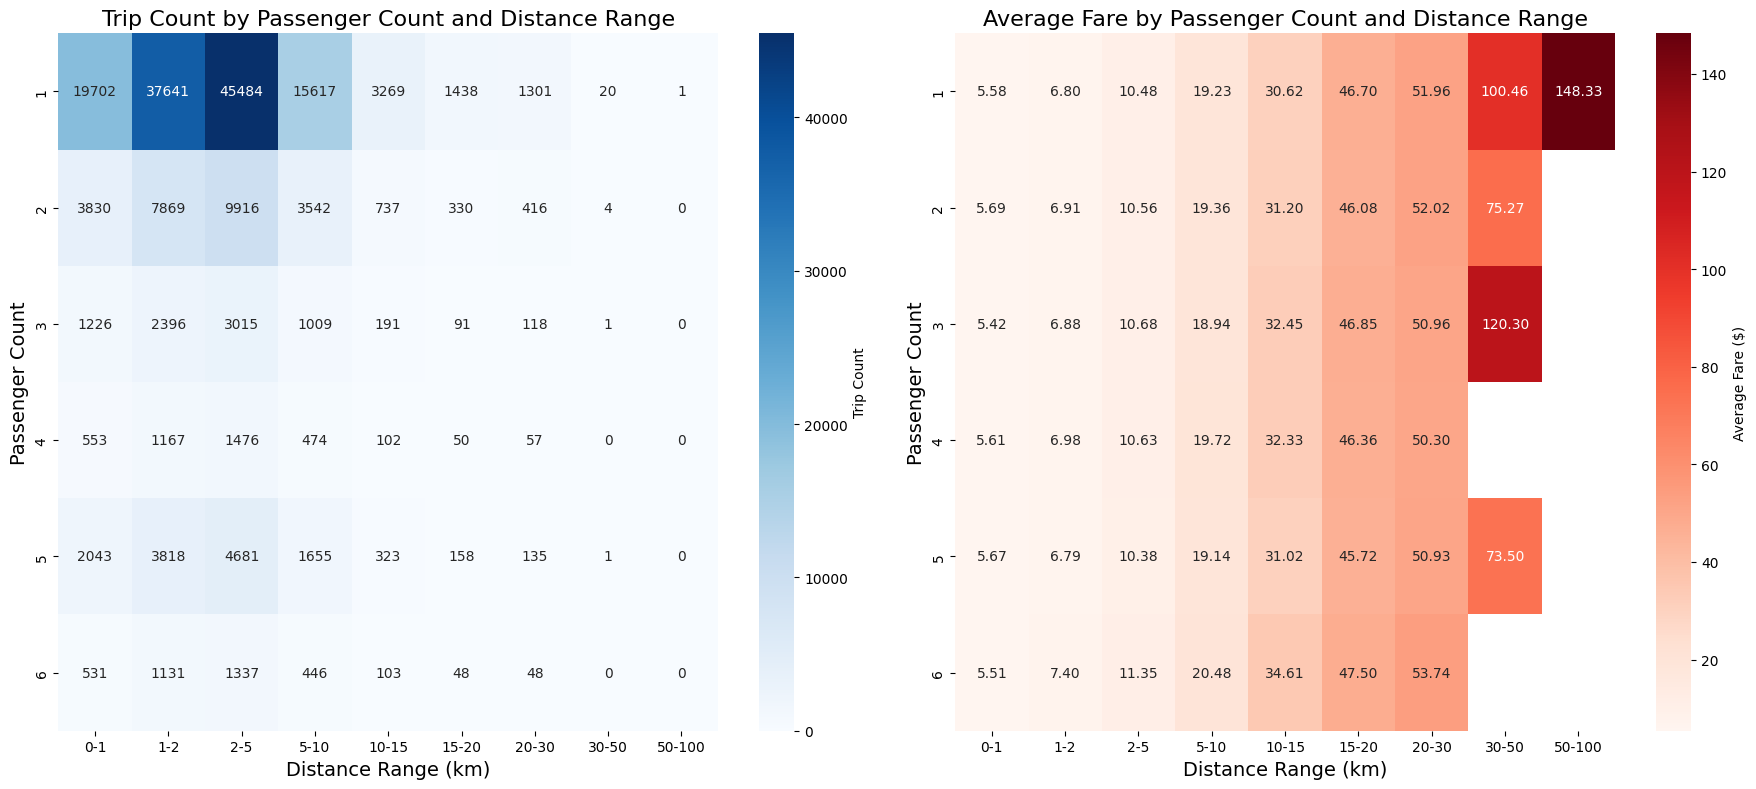

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define bins for distance ranges
bins = [0, 1, 2, 5, 10, 15, 20, 30, 50, 100]
labels = ['0-1', '1-2', '2-5', '5-10', '10-15', '15-20', '20-30', '30-50', '50-100']
data['distance_range'] = pd.cut(data['distance_km'], bins=bins, labels=labels, include_lowest=True)

# Create pivot tables for trip count and average fare
trip_count_pivot = (
    data[(data['passenger_count'] > 0) & (data['passenger_count'] < 10)].groupby(['passenger_count', 'distance_range'])
    .size()
    .unstack(fill_value=0)
)

average_fare_pivot = (
    data[(data['passenger_count'] > 0) & (data['passenger_count'] < 10)].groupby(['passenger_count', 'distance_range'])['fare_amount']
    .mean()
    .unstack(fill_value=0)
)

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left Heatmap: Trip count
sns.heatmap(trip_count_pivot, annot=True, fmt="d", cmap="Blues", ax=axes[0], cbar_kws={'label': 'Trip Count'})
axes[0].set_title('Trip Count by Passenger Count and Distance Range', fontsize=16)
axes[0].set_ylabel('Passenger Count', fontsize=14)
axes[0].set_xlabel('Distance Range (km)', fontsize=14)

# Right Heatmap: Average fare
sns.heatmap(average_fare_pivot, annot=True, fmt=".2f", cmap="Reds", ax=axes[1], cbar_kws={'label': 'Average Fare ($)'})
axes[1].set_title('Average Fare by Passenger Count and Distance Range', fontsize=16)
axes[1].set_ylabel('Passenger Count', fontsize=14)
axes[1].set_xlabel('Distance Range (km)', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_22228\2876719597.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data[(data['passenger_count'] > 0) & (data['passenger_count'] < 10)].groupby(['passenger_count', 'distance_range'])['fare_amount']


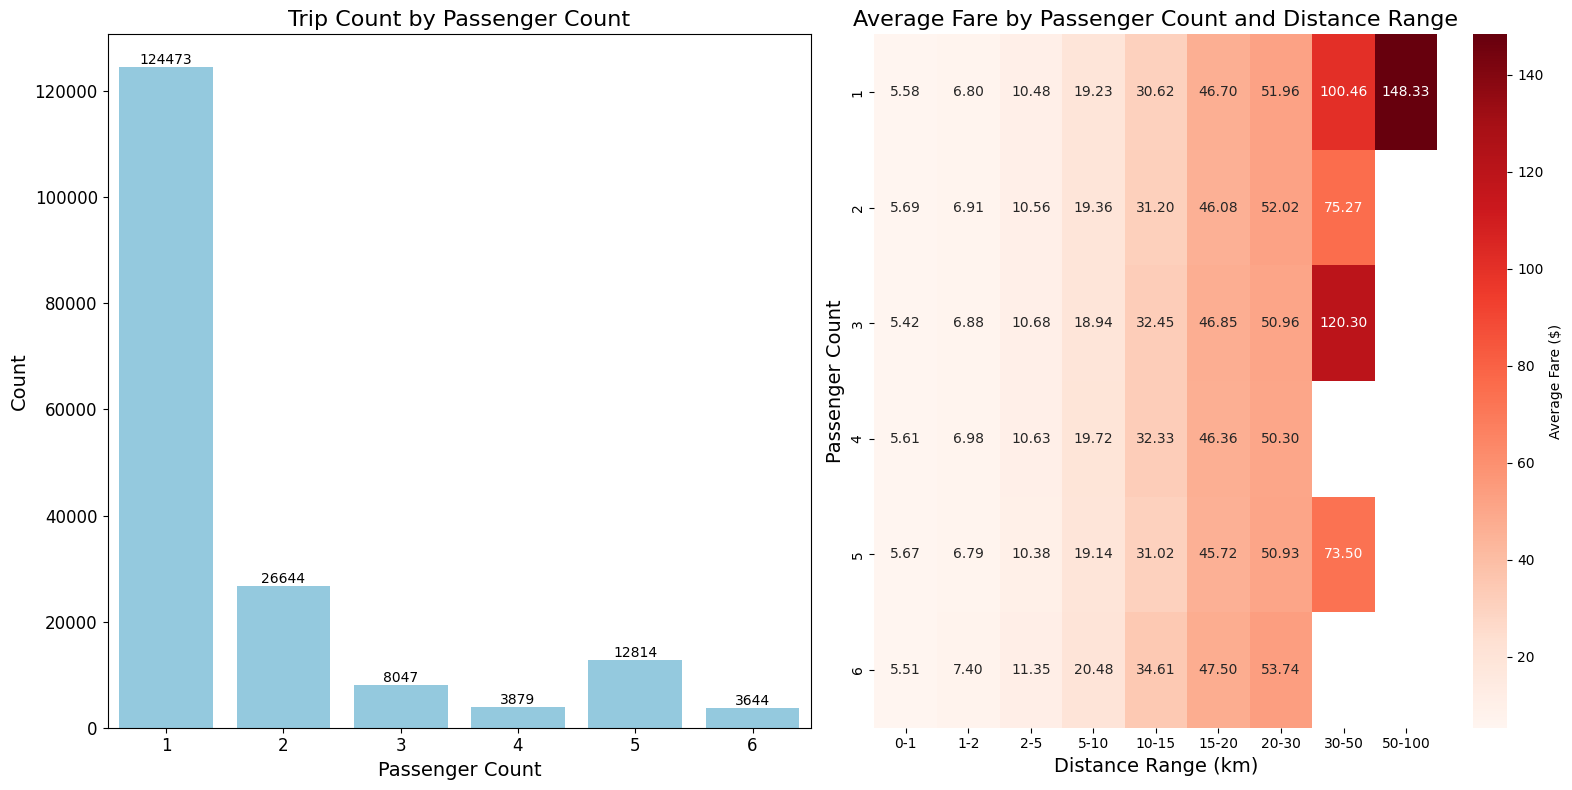

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define bins for distance ranges
bins = [0, 1, 2, 5, 10, 15, 20, 30, 50, 100]
labels = ['0-1', '1-2', '2-5', '5-10', '10-15', '15-20', '20-30', '30-50', '50-100']
data['distance_range'] = pd.cut(data['distance_km'], bins=bins, labels=labels, include_lowest=True)

# Create pivot tables for trip count and average fare
trip_count = data[(data['passenger_count'] > 0) & (data['passenger_count'] < 10)].groupby('passenger_count').size().reset_index(name='count')
trip_count = trip_count.sort_values(by='passenger_count')

average_fare_pivot = (
    data[(data['passenger_count'] > 0) & (data['passenger_count'] < 10)].groupby(['passenger_count', 'distance_range'])['fare_amount']
    .mean()
    .unstack(fill_value=0)
)

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

# Left Plot: Count of trips by passenger_count
sns.barplot(data=trip_count, x='passenger_count', y='count', ax=axes[0], color='skyblue')
axes[0].set_title('Trip Count by Passenger Count', fontsize=16)
axes[0].set_xlabel('Passenger Count', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Add labels above bars for count plot
for bar in axes[0].containers[0]:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                 ha='center', va='bottom', fontsize=10)

# Right Heatmap: Average fare
sns.heatmap(average_fare_pivot, annot=True, fmt=".2f", cmap="Reds", ax=axes[1], cbar_kws={'label': 'Average Fare ($)'})
axes[1].set_title('Average Fare by Passenger Count and Distance Range', fontsize=16)
axes[1].set_ylabel('Passenger Count', fontsize=14)
axes[1].set_xlabel('Distance Range (km)', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_48096\1802794098.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['pickup_month', 'distance_range'])
C:\Users\simon\AppData\Local\Temp\ipykernel_48096\1802794098.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['pickup_month', 'distance_range'])['fare_amount']


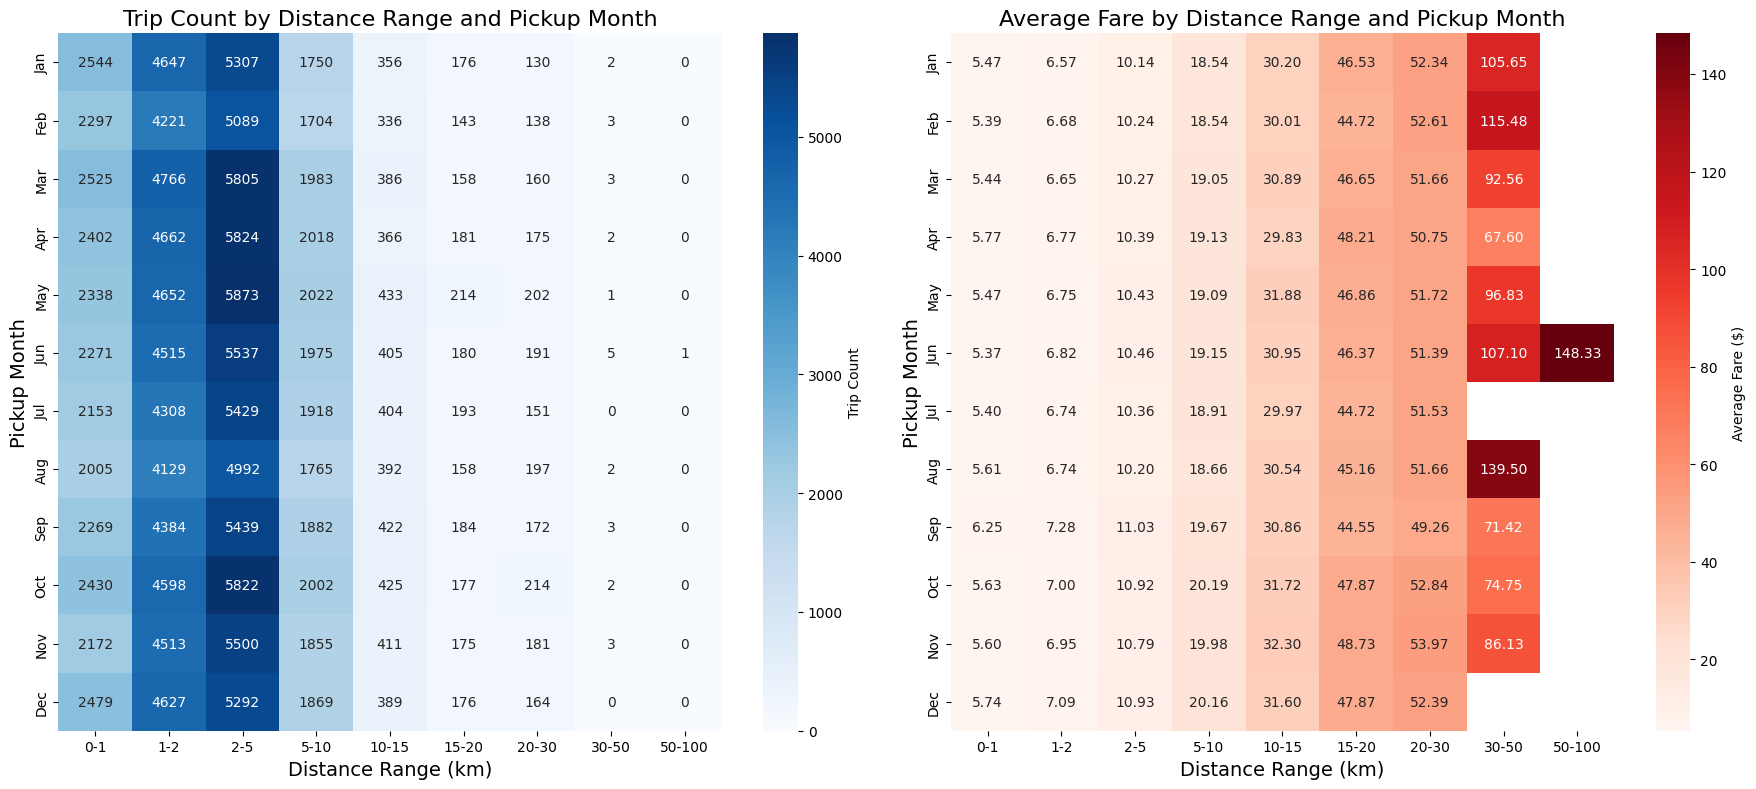

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define bins for distance ranges
bins = [0, 1, 2, 5, 10, 15, 20, 30, 50, 100]
labels = ['0-1', '1-2', '2-5', '5-10', '10-15', '15-20', '20-30', '30-50', '50-100']
data['distance_range'] = pd.cut(data['distance_km'], bins=bins, labels=labels, include_lowest=True)

# Ensure `pickup_month` is treated as a categorical variable for ordering
data['pickup_month'] = pd.Categorical(data['pickup_month'], categories=list(range(1, 13)), ordered=True)

# Create pivot tables for trip count and average fare
trip_count_pivot = (
    data.groupby(['pickup_month', 'distance_range'])
    .size()
    .unstack(fill_value=0)
)

average_fare_pivot = (
    data.groupby(['pickup_month', 'distance_range'])['fare_amount']
    .mean()
    .unstack(fill_value=0)
)

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left Heatmap: Trip count
sns.heatmap(trip_count_pivot, annot=True, fmt="d", cmap="Blues", ax=axes[0], cbar_kws={'label': 'Trip Count'})
axes[0].set_title('Trip Count by Distance Range and Pickup Month', fontsize=16)
axes[0].set_xlabel('Distance Range (km)', fontsize=14)
axes[0].set_ylabel('Pickup Month', fontsize=14)
axes[0].set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Right Heatmap: Average fare
sns.heatmap(average_fare_pivot, annot=True, fmt=".2f", cmap="Reds", ax=axes[1], cbar_kws={'label': 'Average Fare ($)'})
axes[1].set_title('Average Fare by Distance Range and Pickup Month', fontsize=16)
axes[1].set_xlabel('Distance Range (km)', fontsize=14)
axes[1].set_ylabel('Pickup Month', fontsize=14)
axes[1].set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_22228\1409118752.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_count = data[data['pickup_year'] < 2015].groupby('pickup_month').size().reset_index(name='count')
C:\Users\simon\AppData\Local\Temp\ipykernel_22228\1409118752.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['pickup_month', 'distance_range'])['fare_amount']
C:\Users\simon\AppData\Local\Temp\ipykernel_22228\1409118752.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels

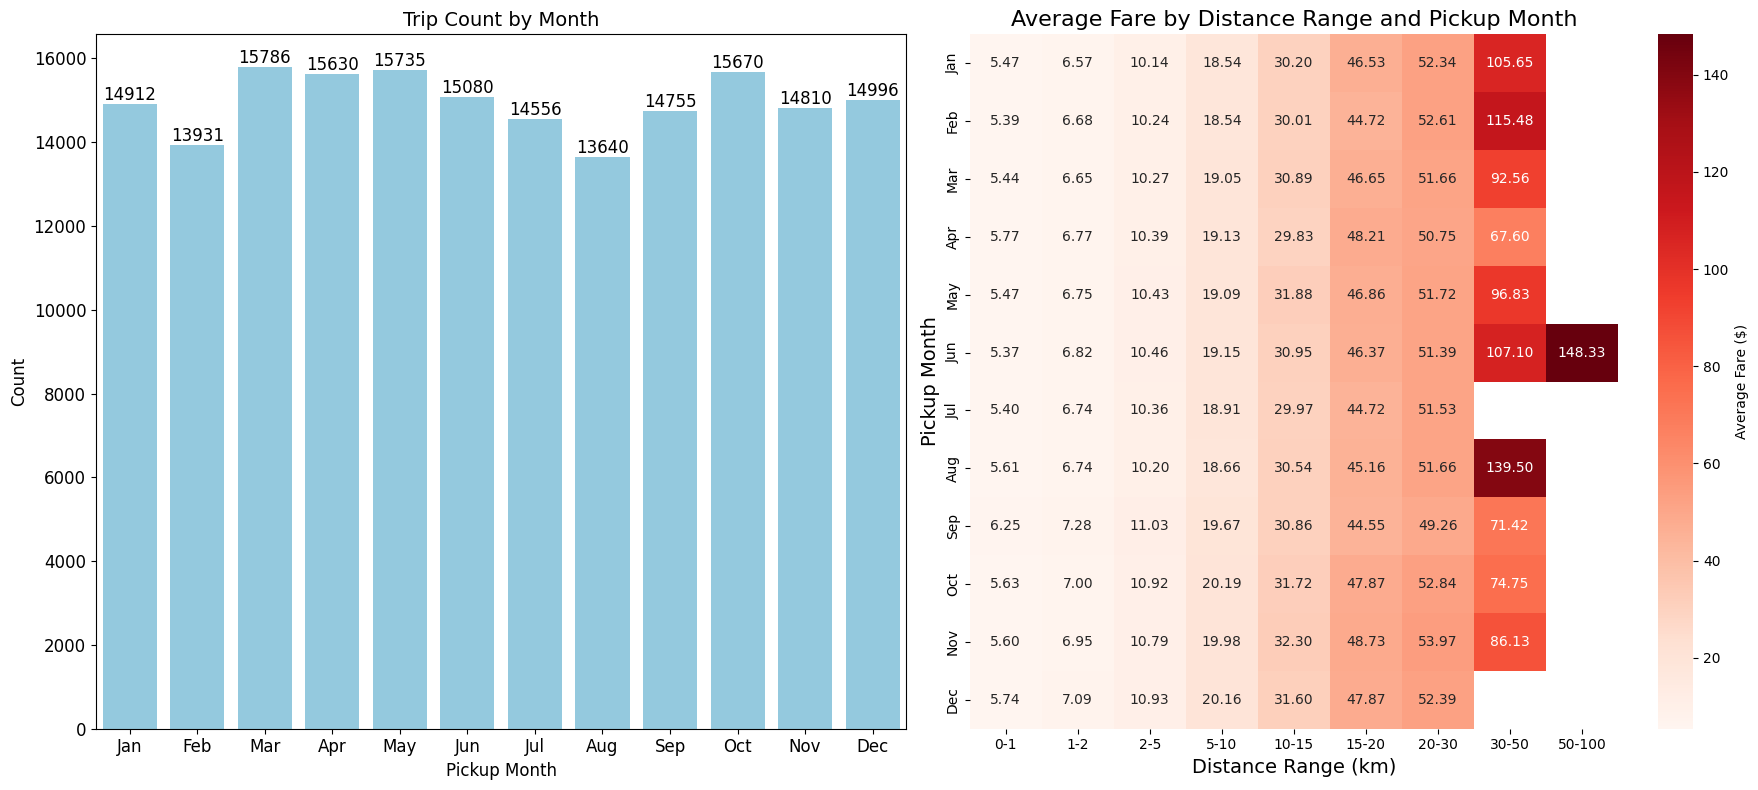

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define bins for distance ranges
bins = [0, 1, 2, 5, 10, 15, 20, 30, 50, 100]
labels = ['0-1', '1-2', '2-5', '5-10', '10-15', '15-20', '20-30', '30-50', '50-100']
data['distance_range'] = pd.cut(data['distance_km'], bins=bins, labels=labels, include_lowest=True)

# Ensure `pickup_month` is treated as a categorical variable for ordering
data['pickup_month'] = pd.Categorical(data['pickup_month'], categories=list(range(1, 13)), ordered=True)

# Create pivot tables for trip count and average fare
trip_count = data[data['pickup_year'] < 2015].groupby('pickup_month').size().reset_index(name='count')
trip_count['pickup_month'] = trip_count['pickup_month'].astype(str)

average_fare_pivot = (
    data.groupby(['pickup_month', 'distance_range'])['fare_amount']
    .mean()
    .unstack(fill_value=0)
)

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left Plot: Count of trips by month
sns.barplot(data=trip_count, x='pickup_month', y='count', ax=axes[0], color='skyblue')  # Use a single color
axes[0].set_title('Trip Count by Month', fontsize=14)
axes[0].set_xlabel('Pickup Month', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', labelsize=12)  # Increase x-tick font size
axes[0].tick_params(axis='y', labelsize=12)  # Increase y-tick font size
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add labels above bars for count plot
for bar in axes[0].containers[0]:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                 ha='center', va='bottom', fontsize=12)


# Right Heatmap: Average fare
sns.heatmap(average_fare_pivot, annot=True, fmt=".2f", cmap="Reds", ax=axes[1], cbar_kws={'label': 'Average Fare ($)'})
axes[1].set_title('Average Fare by Distance Range and Pickup Month', fontsize=16)
axes[1].set_xlabel('Distance Range (km)', fontsize=14)
axes[1].set_ylabel('Pickup Month', fontsize=14)
axes[1].set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_48096\3404877479.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['pickup_weekday', 'distance_range'])
C:\Users\simon\AppData\Local\Temp\ipykernel_48096\3404877479.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['pickup_weekday', 'distance_range'])['fare_amount']


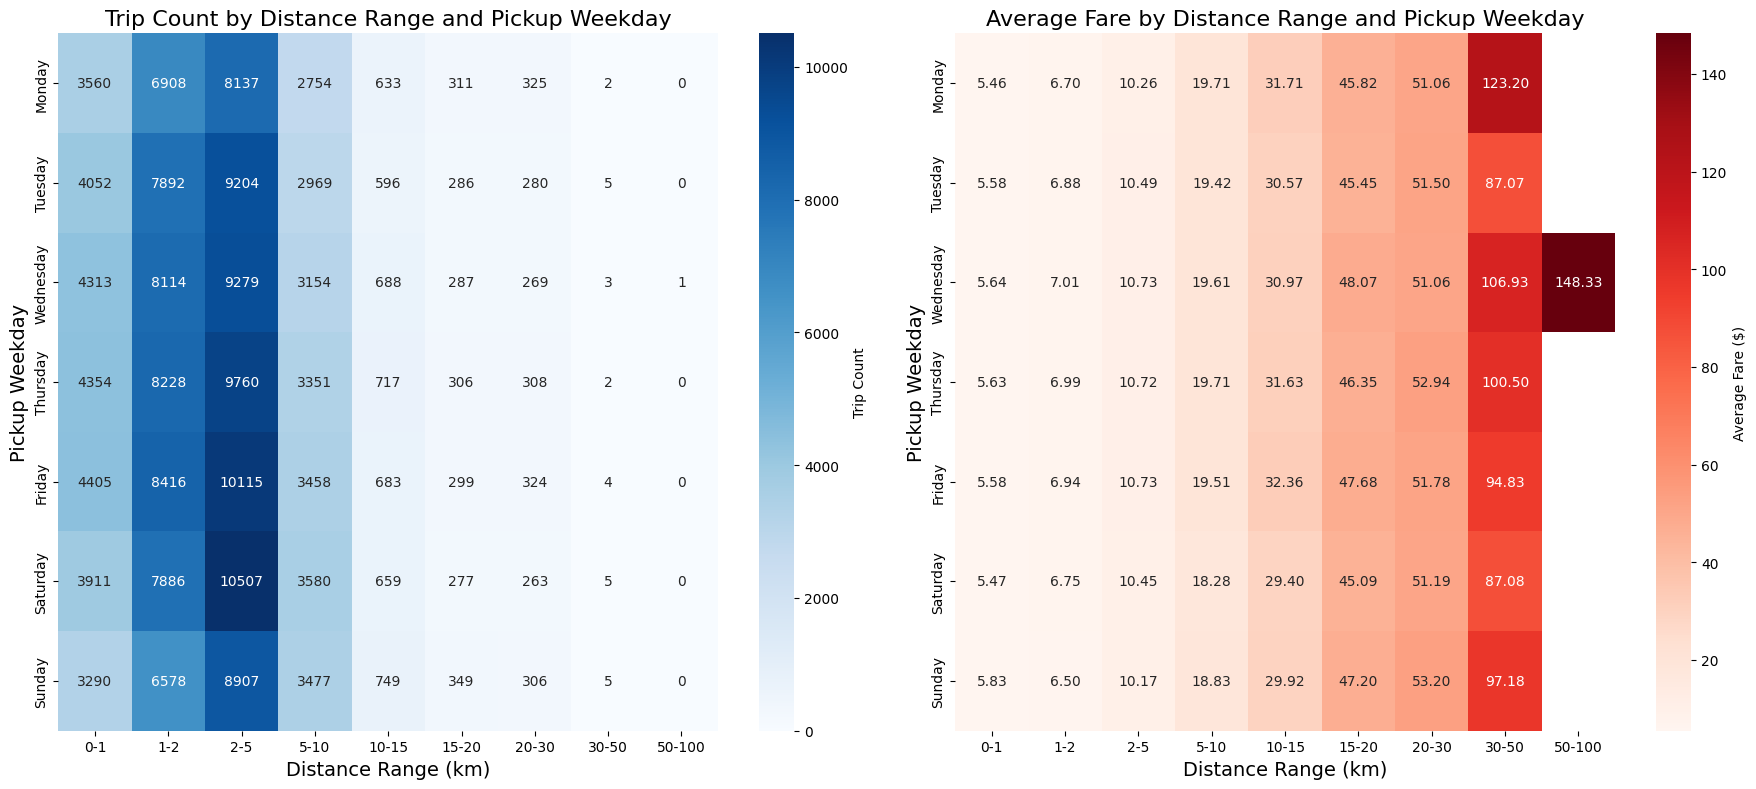

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define bins for distance ranges
bins = [0, 1, 2, 5, 10, 15, 20, 30, 50, 100]
labels = ['0-1', '1-2', '2-5', '5-10', '10-15', '15-20', '20-30', '30-50', '50-100']
data['distance_range'] = pd.cut(data['distance_km'], bins=bins, labels=labels, include_lowest=True)

# Ensure `pickup_weekday` is ordered correctly
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['pickup_weekday'] = pd.Categorical(data['pickup_weekday'], categories=weekday_order, ordered=True)

# Create pivot tables for trip count and average fare
trip_count_pivot = (
    data.groupby(['pickup_weekday', 'distance_range'])
    .size()
    .unstack(fill_value=0)
)

average_fare_pivot = (
    data.groupby(['pickup_weekday', 'distance_range'])['fare_amount']
    .mean()
    .unstack(fill_value=0)
)

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left Heatmap: Trip count
sns.heatmap(trip_count_pivot, annot=True, fmt="d", cmap="Blues", ax=axes[0], cbar_kws={'label': 'Trip Count'})
axes[0].set_title('Trip Count by Distance Range and Pickup Weekday', fontsize=16)
axes[0].set_xlabel('Distance Range (km)', fontsize=14)
axes[0].set_ylabel('Pickup Weekday', fontsize=14)

# Right Heatmap: Average fare
sns.heatmap(average_fare_pivot, annot=True, fmt=".2f", cmap="Reds", ax=axes[1], cbar_kws={'label': 'Average Fare ($)'})
axes[1].set_title('Average Fare by Distance Range and Pickup Weekday', fontsize=16)
axes[1].set_xlabel('Distance Range (km)', fontsize=14)
axes[1].set_ylabel('Pickup Weekday', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_22228\1325073986.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_count = data.groupby('pickup_weekday').size().reset_index(name='count')
C:\Users\simon\AppData\Local\Temp\ipykernel_22228\1325073986.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['pickup_weekday', 'distance_range'])['fare_amount']


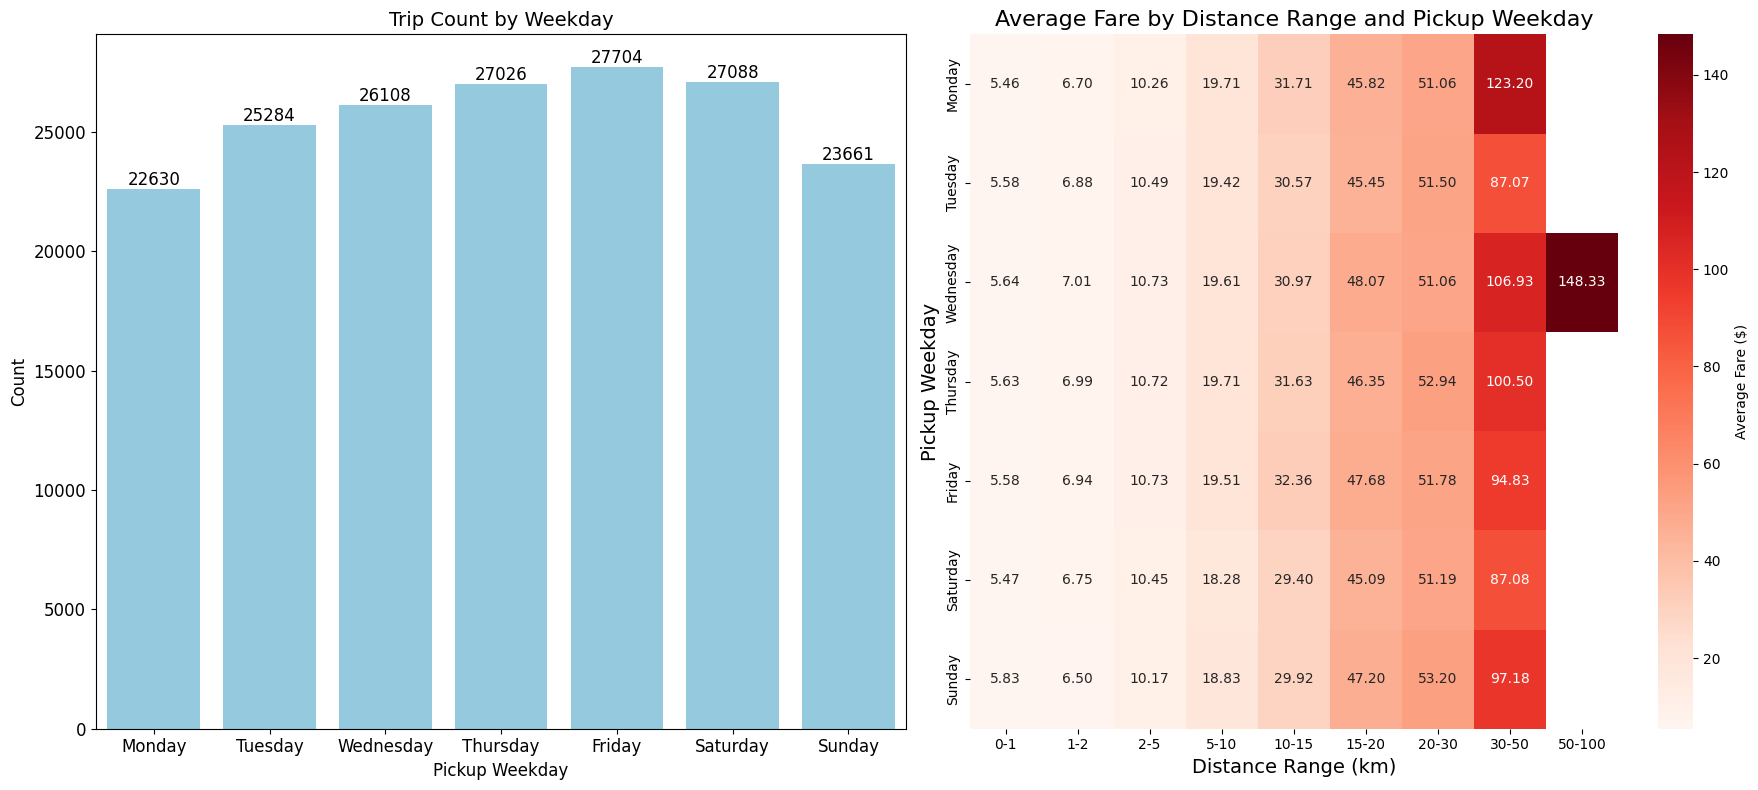

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define bins for distance ranges
bins = [0, 1, 2, 5, 10, 15, 20, 30, 50, 100]
labels = ['0-1', '1-2', '2-5', '5-10', '10-15', '15-20', '20-30', '30-50', '50-100']
data['distance_range'] = pd.cut(data['distance_km'], bins=bins, labels=labels, include_lowest=True)

# Ensure `pickup_weekday` is ordered correctly
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['pickup_weekday'] = pd.Categorical(data['pickup_weekday'], categories=weekday_order, ordered=True)

# Create pivot tables for trip count and average fare
trip_count = data.groupby('pickup_weekday').size().reset_index(name='count')
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trip_count['pickup_weekday'] = pd.Categorical(trip_count['pickup_weekday'], categories=weekday_order, ordered=True)
trip_count = trip_count.sort_values(by='pickup_weekday')

average_fare_pivot = (
    data.groupby(['pickup_weekday', 'distance_range'])['fare_amount']
    .mean()
    .unstack(fill_value=0)
)

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left Plot: Count of trips by weekday
sns.barplot(data=trip_count, x='pickup_weekday', y='count', ax=axes[0], color='skyblue')
axes[0].set_title('Trip Count by Weekday', fontsize=14)
axes[0].set_xlabel('Pickup Weekday', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Add labels above bars for count plot
for bar in axes[0].containers[0]:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                 ha='center', va='bottom', fontsize=12)

# Right Heatmap: Average fare
sns.heatmap(average_fare_pivot, annot=True, fmt=".2f", cmap="Reds", ax=axes[1], cbar_kws={'label': 'Average Fare ($)'})
axes[1].set_title('Average Fare by Distance Range and Pickup Weekday', fontsize=16)
axes[1].set_xlabel('Distance Range (km)', fontsize=14)
axes[1].set_ylabel('Pickup Weekday', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_48096\168736249.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['pickup_hour', 'distance_range'])
C:\Users\simon\AppData\Local\Temp\ipykernel_48096\168736249.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['pickup_hour', 'distance_range'])['fare_amount']


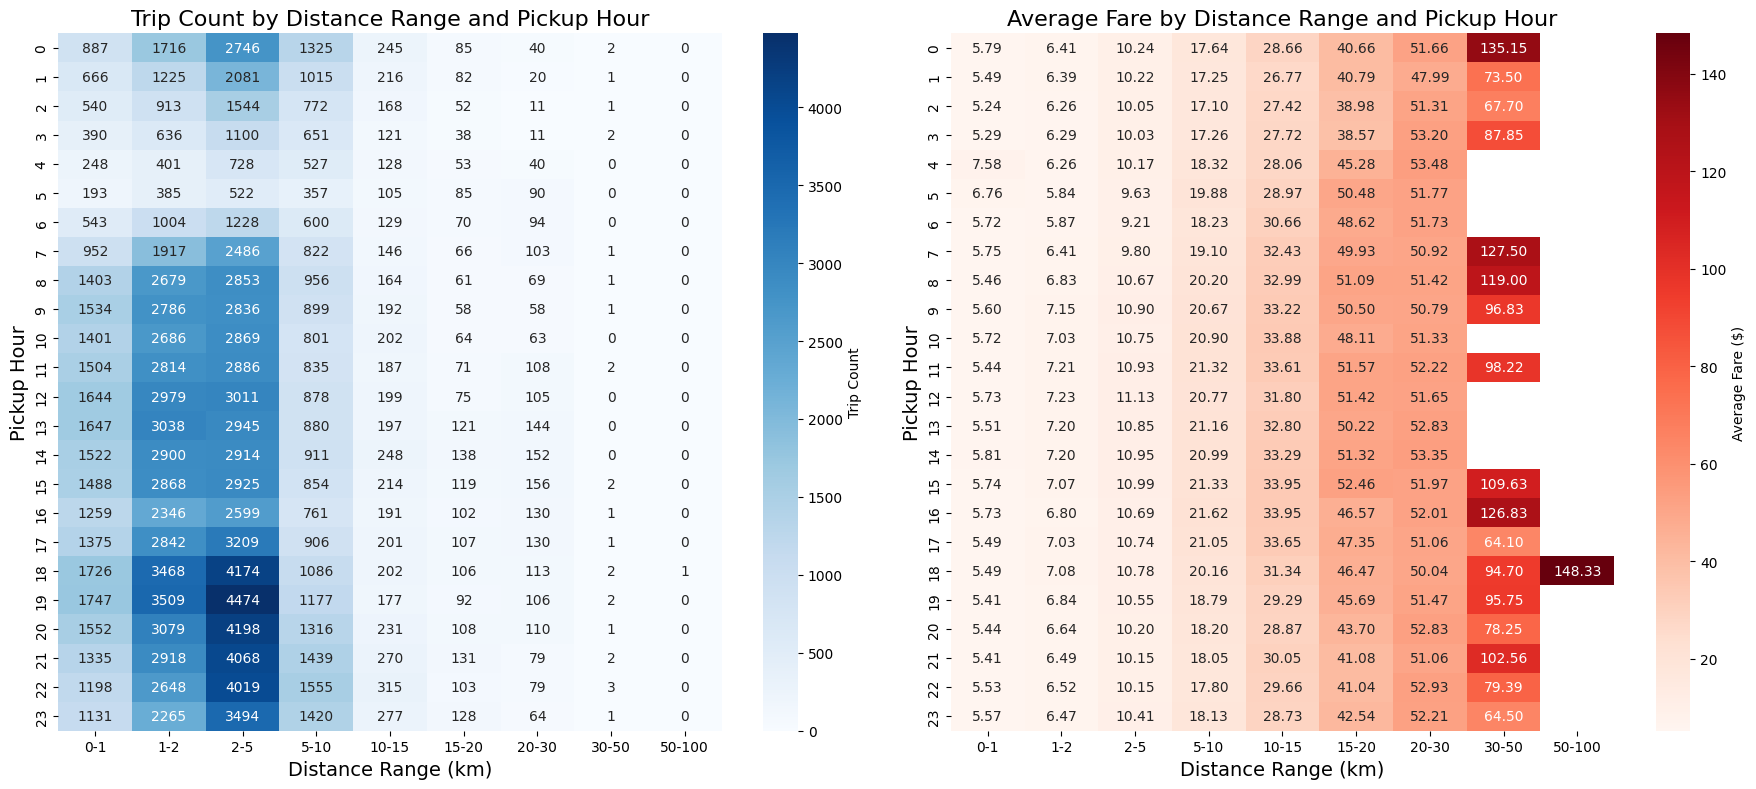

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define bins for distance ranges
bins = [0, 1, 2, 5, 10, 15, 20, 30, 50, 100]
labels = ['0-1', '1-2', '2-5', '5-10', '10-15', '15-20', '20-30', '30-50', '50-100']
data['distance_range'] = pd.cut(data['distance_km'], bins=bins, labels=labels, include_lowest=True)

# Ensure `pickup_hour` is ordered numerically
data['pickup_hour'] = data['pickup_hour'].astype(int)

# Create pivot tables for trip count and average fare
trip_count_pivot = (
    data.groupby(['pickup_hour', 'distance_range'])
    .size()
    .unstack(fill_value=0)
)

average_fare_pivot = (
    data.groupby(['pickup_hour', 'distance_range'])['fare_amount']
    .mean()
    .unstack(fill_value=0)
)

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left Heatmap: Trip count
sns.heatmap(trip_count_pivot, annot=True, fmt="d", cmap="Blues", ax=axes[0], cbar_kws={'label': 'Trip Count'})
axes[0].set_title('Trip Count by Distance Range and Pickup Hour', fontsize=16)
axes[0].set_xlabel('Distance Range (km)', fontsize=14)
axes[0].set_ylabel('Pickup Hour', fontsize=14)

# Right Heatmap: Average fare
sns.heatmap(average_fare_pivot, annot=True, fmt=".2f", cmap="Reds", ax=axes[1], cbar_kws={'label': 'Average Fare ($)'})
axes[1].set_title('Average Fare by Distance Range and Pickup Hour', fontsize=16)
axes[1].set_xlabel('Distance Range (km)', fontsize=14)
axes[1].set_ylabel('Pickup Hour', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


C:\Users\simon\AppData\Local\Temp\ipykernel_22228\1719019859.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['pickup_hour', 'distance_range'])['fare_amount']


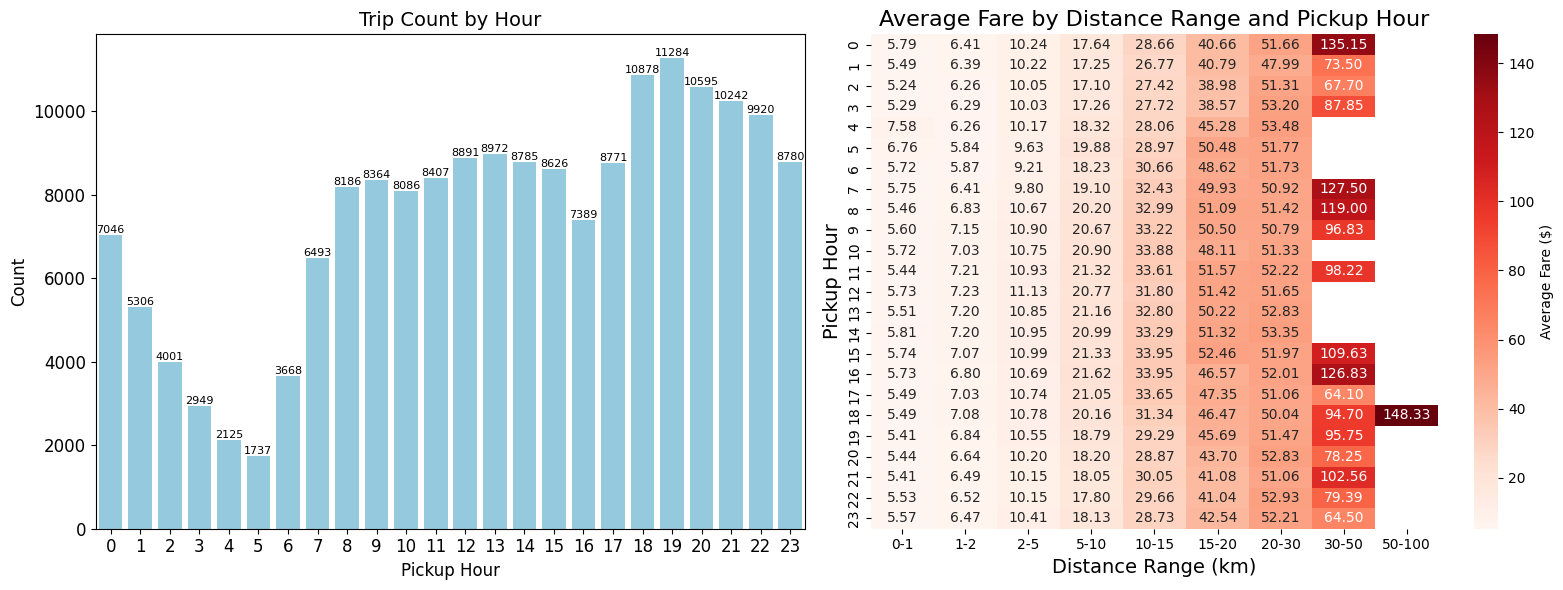

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define bins for distance ranges
bins = [0, 1, 2, 5, 10, 15, 20, 30, 50, 100]
labels = ['0-1', '1-2', '2-5', '5-10', '10-15', '15-20', '20-30', '30-50', '50-100']
data['distance_range'] = pd.cut(data['distance_km'], bins=bins, labels=labels, include_lowest=True)

# Ensure `pickup_hour` is ordered numerically
data['pickup_hour'] = data['pickup_hour'].astype(int)

# Create pivot tables for trip count and average fare
trip_count = data.groupby('pickup_hour').size().reset_index(name='count')
trip_count = trip_count.sort_values(by='pickup_hour')

average_fare_pivot = (
    data.groupby(['pickup_hour', 'distance_range'])['fare_amount']
    .mean()
    .unstack(fill_value=0)
)

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Left Plot: Count of trips by hour
sns.barplot(data=trip_count, x='pickup_hour', y='count', ax=axes[0], color='skyblue')
axes[0].set_title('Trip Count by Hour', fontsize=14)
axes[0].set_xlabel('Pickup Hour', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Add labels above bars for count plot
for bar in axes[0].containers[0]:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', 
                 ha='center', va='bottom', fontsize=8)

# Right Heatmap: Average fare
sns.heatmap(average_fare_pivot, annot=True, fmt=".2f", cmap="Reds", ax=axes[1], cbar_kws={'label': 'Average Fare ($)'})
axes[1].set_title('Average Fare by Distance Range and Pickup Hour', fontsize=16)
axes[1].set_xlabel('Distance Range (km)', fontsize=14)
axes[1].set_ylabel('Pickup Hour', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


develop predictive model for UBER fare

In [52]:
predict_variables = ['fare_amount', 'passenger_count', 'pickup_hour','pickup_month', 'pickup_weekday', 'distance_km']

In [53]:
data[predict_variables].head()

,fare_amount,passenger_count,pickup_hour,pickup_month,pickup_weekday,distance_km
1,7.7,1,20,7,Friday,2.457590
2,12.9,1,21,8,Monday,5.036377
3,5.3,3,8,6,Friday,1.661683
4,16.0,5,17,8,Thursday,4.475450
6,24.5,5,7,10,Sunday,11.731015


In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predict_variables = ['fare_amount', 'passenger_count', 'pickup_hour','pickup_month', 'pickup_weekday', 'distance_km']
# Treat categorical variables properly
categorical_vars = ['passenger_count', 'pickup_hour', 'pickup_month', 'pickup_weekday']
# data = pd.get_dummies(data, columns=categorical_vars, drop_first=True)

# Split the data into features (X) and target (y)
X = pd.get_dummies(data[predict_variables], columns=categorical_vars, drop_first=True).drop(columns=['fare_amount'])
y = data['fare_amount']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mae_reg = mean_absolute_error(y_test, y_pred)
mse_reg = mean_squared_error(y_test, y_pred)
r2_reg = r2_score(y_test, y_pred)

# Print performance metrics
print("Regression Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_reg:.2f}")
# print(f"Mean Squared Error (MSE): {mse_reg:.2f}")
print(f"R-squared (R^2): {r2_reg:.2f}")

# Analyze feature importance
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(coefficients)

# Template for interpreting results
template = """
Regression Analysis Results:
- The model predicts fare_amount based on several features, including passenger_count, pickup time (hour, month, weekday), and distance.
- The R-squared value indicates that the model explains {:.2f}% of the variance in fare_amount.
- Significant features (based on coefficients) are:
  1. {}
  2. {}
  3. {}
- MAE and MSE suggest that the average prediction error is {:.2f} and {:.2f} squared units, respectively.
"""
print(template.format(r2_reg * 100, 
                      coefficients.iloc[0]['Feature'], 
                      coefficients.iloc[1]['Feature'], 
                      coefficients.iloc[2]['Feature'], 
                      mae_reg, mse_reg))


Regression Model Performance:
Mean Absolute Error (MAE): 2.26
R-squared (R^2): 0.73

Feature Importance:
                     Feature  Coefficient
0                distance_km     2.322500
19            pickup_hour_14     1.388262
17            pickup_hour_12     1.315604
20            pickup_hour_15     1.275267
16            pickup_hour_11     1.216853
14             pickup_hour_9     1.205832
18            pickup_hour_13     1.203347
21            pickup_hour_16     1.118514
22            pickup_hour_17     1.100708
15            pickup_hour_10     1.069960
13             pickup_hour_8     0.899490
23            pickup_hour_18     0.877144
5          passenger_count_6     0.712035
36            pickup_month_9     0.675899
37           pickup_month_10     0.663666
39           pickup_month_12     0.650400
38           pickup_month_11     0.647841
24            pickup_hour_19     0.575226
42   pickup_weekday_Thursday     0.412422
43     pickup_weekday_Friday     0.411675
41  pickup_we

In [72]:
coefficients

,Feature,Coefficient
0,distance_km,2.322500
19,pickup_hour_14,1.388262
17,pickup_hour_12,1.315604
20,pickup_hour_15,1.275267
16,pickup_hour_11,1.216853
14,pickup_hour_9,1.205832
18,pickup_hour_13,1.203347
21,pickup_hour_16,1.118514
22,pickup_hour_17,1.100708
15,pickup_hour_10,1.069960


In [58]:
# Encode days of the week as numbers
weekday_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
data['pickup_weekday_encoded'] = data['pickup_weekday'].map(weekday_mapping)

In [59]:
predict_variables = ['fare_amount', 'passenger_count', 'pickup_hour','pickup_month', 'pickup_weekday_encoded', 'distance_km']

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb

# Split the data into features (X) and target (y)
X = data[predict_variables].drop(columns=['fare_amount'])
y = data['fare_amount']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
}

# Initialize results dictionary
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print('{} building....'.format(model_name))
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[model_name] = {"MAE": mae, "R2": r2}

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T

# Explanation of Model Comparison
best_model = results_df['R2'].idxmax()
best_r2 = results_df.loc[best_model, 'R2']
best_mae = results_df.loc[best_model, 'MAE']

explanation = f"""
Model Comparison Analysis:
- The best-performing model is {best_model} with the highest R2 score of {best_r2:.2f}, indicating it explains the most variance in fare_amount.
- The MAE for {best_model} is {best_mae:.2f}, indicating the average error in predictions.
- Decision Tree provides interpretable models but may overfit with limited data.
- Random Forest and XGBoost are robust ensemble models that handle complex data well, often outperforming simpler algorithms.
"""
print(explanation)
new_row = pd.DataFrame({
    "MAE": mae_reg,  # Replace with the actual MAE value for the new model
    "R2": r2_reg    # Replace with the actual R2 value for the new model
}, index=["Regression"])  # Replace "Additional Model" with the actual name

updated_results_df = pd.concat([results_df, new_row])
updated_results_df

Decision Tree building....
Random Forest building....
XGBoost building....

Model Comparison Analysis:
- The best-performing model is XGBoost with the highest R2 score of 0.73, indicating it explains the most variance in fare_amount.
- The MAE for XGBoost is 2.24, indicating the average error in predictions.
- Decision Tree provides interpretable models but may overfit with limited data.
- Random Forest and XGBoost are robust ensemble models that handle complex data well, often outperforming simpler algorithms.
- SVR is suitable for smaller datasets and captures linear and non-linear relationships effectively.



,MAE,R2
Decision Tree,3.237140,0.537366
Random Forest,2.375256,0.727114
XGBoost,2.236225,0.730663
Regression,2.261416,0.728671


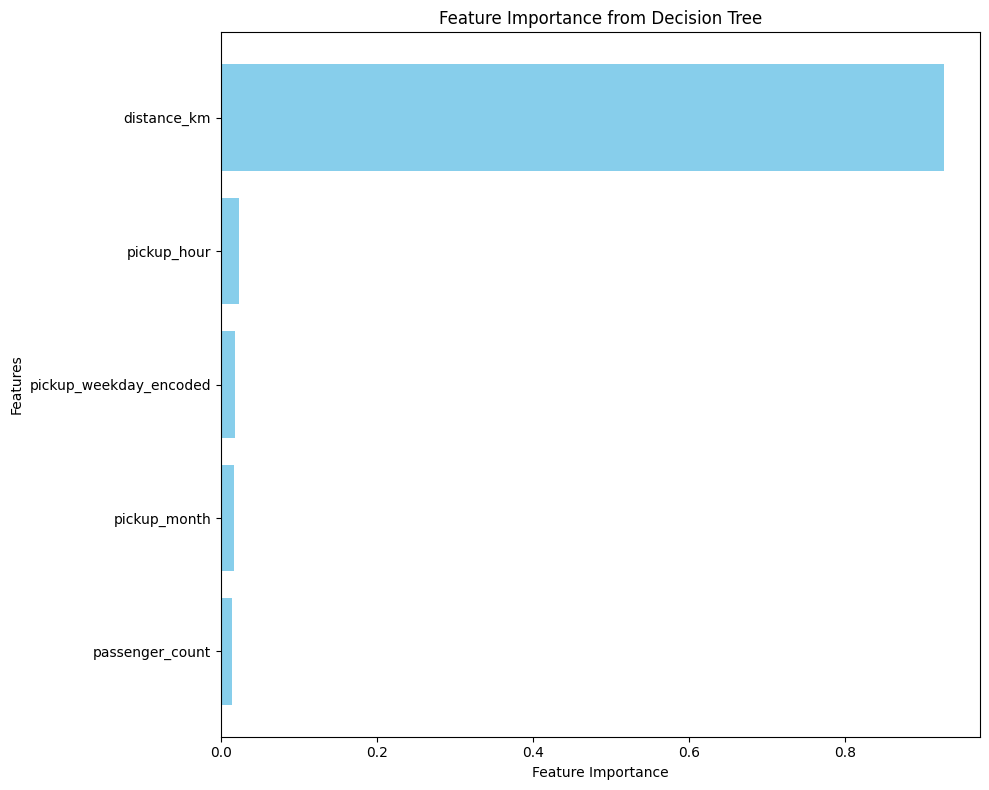

In [62]:
import matplotlib.pyplot as plt
# Feature Importance Plot
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Decision Tree')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

| **Question**                                                                 | **Answer**                                                                                                              |
|------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------|
| **What are the primary factors influencing Uber fare prices?**               | - Distance traveled is the most significant factor, with longer trips resulting in higher fares.                        |
|                                                                              | - Pickup time (hour of the day) influences prices, with peak hours typically showing higher fares.                      |
|                                                                              | - Day of the week impacts fares, with weekdays showing variations in demand-based pricing.                              |
|                                                                              | - Passenger count can moderately influence fare adjustments.                                                           |
| **How do fare prices vary based on time of day, day of the week, and location?** | - Prices are higher during peak hours (e.g., morning and evening rush hours).                                           |
|                                                                              | - Weekends and late-night hours may show fare surges due to higher demand.                                              |
|                                                                              | - Urban areas or locations with high demand tend to have higher fares.                                                  |
| **What is the optimal time frame for users to book rides to secure the best rates?** | - Early morning (non-peak hours) and midday hours generally have the lowest fares.                                     |
|                                                                              | - Avoid booking during rush hours and late-night periods when demand surges are common.                                 |
| **How can users be notified of potential fare changes when making a reservation?** | - Implement real-time notifications in the app for fare changes based on location, time of day, and upcoming events.   |
|                                                                              | - Provide predictive fare estimates during the booking process to inform users of potential surges.                     |
|                                                                              | - Send push notifications or emails highlighting low-fare periods or upcoming discounts.                                |
